In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [8]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
rice-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile

def extract_zip_to_directory(zip_path, extract_dir):
    """
    Extracts the contents of a ZIP file to a specified directory.

    Parameters:
    zip_path (str): Path to the ZIP file.
    extract_dir (str): Directory where the contents should be extracted.
    """
    # Create the target directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Open the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents into the target directory
        zip_ref.extractall(extract_dir)

# Example usage
zip_path = '/content/rice-image-dataset.zip'  # Path to your ZIP file
extract_dir = '/content/sample_data'  # Directory where you want to extract the files

extract_zip_to_directory(zip_path, extract_dir)


In [10]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from PIL import Image

resize_transforms = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

in_folders = ['./Rice/Ipsala/', './Rice/Arborio/', './Rice/Basmati/', './Rice/Jasmine/','./Rice/Karacadag/' ]

# Path to the root directory containing subdirectories for each class
root_dir = './sample_data/Rice_Image_Dataset'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=root_dir, transform=resize_transforms)

# Define batch size
batch_size = 256

# Determine the sizes of the training and test datasets
total_size = len(dataset)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size  # Remaining 80% for training

# Split the dataset into training and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=4)

In [11]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(4)

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(16 * 32 * 32, 15)  # Adjust according to the image size
        self.bn3 = nn.BatchNorm1d(15)
        self.fc2 = nn.Linear(15, 5)          # Number of output classes

    def forward(self, x):
        x = self.pool(torch.tanh(self.bn1(self.conv1(x))))
        x = self.pool(torch.tanh(self.bn2(self.conv2(x))))

        x = x.view(-1, 16 * 32 * 32)  # Flatten the tensor

        x = torch.tanh((self.fc1(x)))
        x = self.bn3(x)

        x = self.fc2(x)

        return x

In [12]:
import math

# Hyper Parameters
criterion = nn.CrossEntropyLoss()
model = SimpleCNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95)

train_losses = []
val_losses = []

epochs = 2
total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/256)

# Training

for epoch in range(epochs):

    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        print(f'epoch {epoch+1}/{epochs}, step {i+1} / {n_iterations} ')

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'loss = {loss}')
        train_losses.append(loss.item())

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            avg_val_loss = 0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                print(f'Validation Loss = {loss.item()}')
                val_losses.append(loss.item())
                break


# Assume `model` is your trained PyTorch model
# Save the model's state dictionary
torch.save(model.state_dict(), 'model_weights.pth')


# nv1 = nn.Conv2d(in_channels = 3, out_channels= 16, kernel_size=3, stride=1, padding=1)
# nv2 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size=3, stride=1, padding=1)
# nv3 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size=3, stride=1, padding=1)
#
# pool = nn.MaxPool2d(2, 2)
# for batch_idx, (inputs, labels) in enumerate(train_loader):
#     print(f'Batch {batch_idx + 1}:')
#     print(f'Inputs shape: {inputs.shape}')
#     print(f'Labels shape: {labels.shape}')
#     x = conv1(inputs)
#     print(f'x_shape = {x.shape}')
#     x = pool(x)
#     print(f'x_shape = {x.shape}')
#     x = conv2(x)
#     print(f'x_shape = {x.shape}')
#     x = pool(x)
#     print(f'x_shape = {x.shape}')
#     x = conv3(x)
#     print(f'x_shape = {x.shape}')
#     x = pool(x)
#     print(f'x_shape = {x.shape}')
#     # Process the batch
#     break

epoch 1/2, step 1 / 235 
loss = 1.7911330461502075
Validation Loss = 1.5586812496185303
epoch 1/2, step 2 / 235 
loss = 1.5612422227859497
Validation Loss = 1.5350086688995361
epoch 1/2, step 3 / 235 
loss = 1.5291118621826172
Validation Loss = 1.5087954998016357
epoch 1/2, step 4 / 235 
loss = 1.4872766733169556
Validation Loss = 1.4662855863571167
epoch 1/2, step 5 / 235 
loss = 1.469583511352539
Validation Loss = 1.4349421262741089
epoch 1/2, step 6 / 235 
loss = 1.4524600505828857
Validation Loss = 1.352931022644043
epoch 1/2, step 7 / 235 
loss = 1.3600153923034668
Validation Loss = 1.3003251552581787
epoch 1/2, step 8 / 235 
loss = 1.2905683517456055
Validation Loss = 1.2673423290252686
epoch 1/2, step 9 / 235 
loss = 1.2783738374710083
Validation Loss = 1.2263132333755493
epoch 1/2, step 10 / 235 
loss = 1.2268791198730469
Validation Loss = 1.1611502170562744
epoch 1/2, step 11 / 235 
loss = 1.1581664085388184
Validation Loss = 1.0994696617126465
epoch 1/2, step 12 / 235 
loss =

In [13]:
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

            outputs = model(inputs)  # Forward pass

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with the highest probability

            total += labels.size(0)  # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Increment the number of correct predictions

    accuracy = (correct / total) * 100  # Calculate accuracy as a percentage
    return accuracy

calculate_accuracy(model, test_loader, 'cpu')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


96.52

470
470


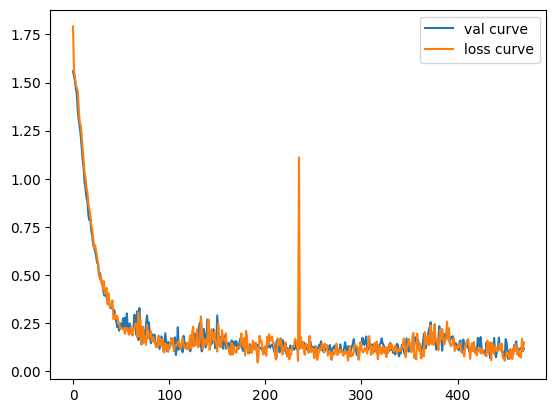

In [14]:
import matplotlib.pyplot as plt

print(len(val_losses))
print(len(train_losses))

plt.plot(list(range(len(train_losses))),val_losses, label='val curve')
plt.plot(list(range(len(train_losses))),train_losses, label='loss curve')
plt.legend()
plt.show()